In [1]:
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

device = torch.device('cpu')

In [2]:
import numpy as np

In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask):
        super(RealNVP, self).__init__()
        
        self.mask = nn.Parameter(mask, requires_grad=False).to(device)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def f(self, z):
        x = z
        log_det_J = z.new_zeros(z.shape[0])
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            log_det_J += s.sum(dim=1)
        return x, log_det_J

    def f_inv(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

In [4]:
n,p = int(100),100

X = torch.randn(n,p).to(device)

d = 5


w0 = torch.from_numpy(np.array([(np.random.normal(5,1,[d])).tolist() +[0]*(p-d)]).astype(np.float32)).t().to(device)


psi = (X@w0)[:,0]


y = psi + torch.rand(n).to(device) * 0.1

In [5]:
total_param = p + 4 # needs to be even


latent_dim = 256

mask1 = [0,1]* int(total_param/2)
mask2 = [1- x for x in mask1]

nets = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, total_param), nn.Tanh()).to(device)
nett = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, total_param)).to(device)
masks = torch.from_numpy(np.array([mask1, mask2] * 4).astype(np.float32)).to(device)


K =1

flow_list = [RealNVP(nets, nett, masks) for _ in range(K)]

net_pi = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), 
                               nn.LeakyReLU(), nn.Linear(latent_dim, K), nn.Softmax(dim=1)).to(device)

flow_pi = net_pi()

In [6]:
batch_size = 200

In [7]:
beta = torch.rand([batch_size, total_param]).to(device)

In [8]:
beta.shape

torch.Size([200, 104])

In [9]:
def f_(w, r):
    idx = 0
    idx1 = idx + p
    abs_w = torch.abs(w).to(device)
    sorted_w, argsort_w = abs_w.sort(descending = True)

    mu = torch.zeros(p, batch_size).to(device)
    K_ = torch.zeros(p, batch_size).to(device)
   
    for i in range(p):
        mu[i] = sorted_w[:,0:i+1].sum(dim = 1)-r
        K_[i] = sorted_w[:,i] > mu[i]/(i+1)
    K_ = K_.sum(dim = 0).type(torch.int64)
    
    mu_k = torch.zeros(batch_size).to(device)
    scaled_mu_k = torch.zeros([batch_size,1]).to(device)
    for j in range(batch_size):
        mu_k[j] = mu[K_[j], j]
        scaled_mu_k[j,0] = mu[K_[j], j]/(K_[j] + 1)
    s = torch.sign(w).to(device)
    
    t = abs_w-torch.repeat_interleave(scaled_mu_k, p, dim=1)
    eta = s.t()*torch.max(t.t(), torch.zeros(p,batch_size).to(device))
    return eta

In [10]:
def loglik(theta):
    idx = 0
    idx1 = idx + p
    w = theta[:,idx: idx1]
    
    idx = idx1
    idx1 = idx + 1
    r = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    
    idx = idx1
    idx1 = idx + 1
    lam = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    
    idx = idx1
    idx1 = idx + 1
    sigma2 = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    
    prior_w = - w.abs().sum(1)/lam -  p* torch.log(lam)
    prior_r = - torch.log(1 + r**2) 
    prior_lam = - torch.log(1 + lam**2) 
    prior_sigma2 =  - torch.log(1 + sigma2) 

    n = y.shape[0]
    
    eta = f_(w, r)
    psi = (eta.t())@X.t()
    lik =  -((y - psi)**2).sum(1)/2.0 /sigma2 - n*torch.log(sigma2) /2.0
    
    total_posterior= lik + prior_w + prior_lam + prior_r + prior_sigma2
    
    return total_posterior

In [11]:
# theta = z_cad
# idx = 0
# idx1 = idx + p
# w = theta[:,idx: idx1]

# idx = idx1
# idx1 = idx + 1
# r = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())

# idx = idx1
# idx1 = idx + 1
# lam = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())

# idx = idx1
# idx1 = idx + 1
# sigma2 = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())

# prior_w = - w.abs().sum(1)/lam -  p* torch.log(lam)
# prior_r = - torch.log(1 + r**2) 
# prior_lam = - torch.log(1 + lam**2) 
# prior_sigma2 =  - torch.log(1 + sigma2) 

# n = y.shape[0]

# eta = f_(w, r)
# psi = (eta.t())@X.t()
# lik =  -((y - psi)**2).sum(1)/2.0 /sigma2 - n*torch.log(sigma2) /2.0

# total_posterior= lik + prior_w + prior_lam + prior_r + prior_sigma2

In [12]:
# idx = 0
# idx1 = idx + p
# abs_w = torch.abs(w).to(device)
# sorted_w, argsort_w = abs_w.sort(descending = True)


In [13]:
# mu = torch.zeros(p, batch_size).to(device)
# K_ = torch.zeros(p, batch_size).to(device)

# for i in range(p):
#     mu[i] = sorted_w[:,0:i+1].sum(dim = 1)-r
#     K_[i] = sorted_w[:,i] > mu[i]/(i+1)
# K_ = K_.sum(dim = 0).type(torch.int64)

In [14]:
def log_reference(z):
    return  0 #- torch.sum((z/ref_sigma).pow(2)/2.0,dim=1)

In [15]:
para_list = list()

In [16]:
for flow in flow_list:
    para_list+= list(flow.parameters())
    
para_list +=  list(flow_pi.parameters())

In [17]:
from torch.distributions import gumbel

In [18]:
gum_rng= gumbel.Gumbel(0,1)


def soft_multinomial(Pi):
    lam = 0.1
    return torch.softmax((Pi.log() + gum_rng.sample(Pi.shape).to(device))/lam,1)


def soft_multinomial_log(logPi):
    lam = 0.1
    return torch.softmax((logPi + gum_rng.sample(logPi.shape).to(device))/lam,1)

In [19]:
import copy


best_loss = np.inf

In [20]:
def get_z(model, x):
    
    flow_list = model[0]
    flow_pi = model[1]
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(x)
        Loglik_list.append(compLoglik.f(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
        z_list.append(z_cad) 
        
    total_loglik = torch.logsumexp(torch.stack(Loglik_list), dim=0)
        
    loss =  -  total_loglik.mean()
        
    c = soft_multinomial_log(torch.stack(Loglik_list).t())
    z_candidates = torch.stack(z_list)
    z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(x.shape[0])])
    
    return z

In [21]:
best_model= copy.deepcopy([flow_list , flow_pi])

In [22]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-4)

In [23]:
for t in range(1000):
    
    beta =  torch.rand([batch_size, total_param]).to(device)
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(beta)
        Loglik_list.append(loglik(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
#         z_list.append(z_cad) 
        
    g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)
        
    loss =    g.mean() 
    
    if t%50==0:
        print(t, loss.item(), z_cad[1,p].item())
    
    if loss.item()< best_loss:
        best_model= copy.deepcopy([flow_list , flow_pi])
        best_loss = loss.item()
        
    if np.isnan(loss.cpu().data.numpy()):    
        flow_list,flow_pi = best_model
          

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

0 6178.8369140625 0.20928093791007996
50 407.98309326171875 1.7980778217315674
100 277.9842834472656 2.607663154602051
150 242.2277374267578 10.3452787399292
200 209.55331420898438 28.259815216064453
250 197.59121704101562 18.719614028930664
300 185.71116638183594 23.526058197021484
350 173.02769470214844 27.10003662109375
400 150.29901123046875 28.006328582763672
450 103.37738037109375 25.37685775756836
500 53.995880126953125 24.13849449157715
550 20.485136032104492 25.01071548461914
600 -8.604568481445312 23.35333251953125
650 -26.73676300048828 23.303279876708984
700 -47.375526428222656 24.028959274291992
750 -50.828369140625 24.461078643798828
800 -69.15153503417969 24.461977005004883
850 -68.36168670654297 24.265552520751953
900 -84.4569320678711 24.760122299194336
950 -83.45513916015625 24.405014038085938


In [24]:
beta =  torch.rand([batch_size, total_param]).to(device) 

Loglik_list = list()
z_list = list()

for k in range(K):

    flow = flow_list[k]
    z_cad, logdetJ = flow.f(beta)
    Loglik_list.append(loglik(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
    z_list.append(z_cad) 

g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)

loss =    g.mean() 


c = soft_multinomial_log(torch.stack(Loglik_list).t())
z_candidates = torch.stack(z_list)

z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(beta.shape[0])])


In [25]:
w = z[:,0:p]
r = z[:,p]
w_post = f_(w,r).t()

w_post = w_post.cpu().detach().numpy()

In [26]:
(w_post[np.logical_not(np.isnan(w_post[:,0]))]).mean(axis=0)[:d+5]

array([ 4.9018373e+00,  4.8926473e+00,  5.6040730e+00,  4.3702378e+00,
        4.8825965e+00,  0.0000000e+00, -5.7985546e-04,  0.0000000e+00,
       -4.1510223e-04,  0.0000000e+00], dtype=float32)

In [27]:
import seaborn as sns
import pandas as pd

In [28]:
w5 = pd.DataFrame( {'Value': w_post[:,:10].flatten(order='F'), 
                    'w': np.repeat(np.arange(1,11),w_post.shape[0]),
                    'Method': "Transport"
                   })

In [29]:
w5_2 = pd.DataFrame( {'Value': np.repeat(w0.cpu().numpy()[:5],w_post.shape[0]) + 
                      np.random.randn(5*w_post.shape[0])*0.01, 
                    'w': np.repeat(np.arange(1,6),w_post.shape[0]),
                    'Method': "Oracle"
                   })

In [30]:
w_long = pd.concat([w5, w5_2])

In [31]:
w_post.shape

(200, 100)

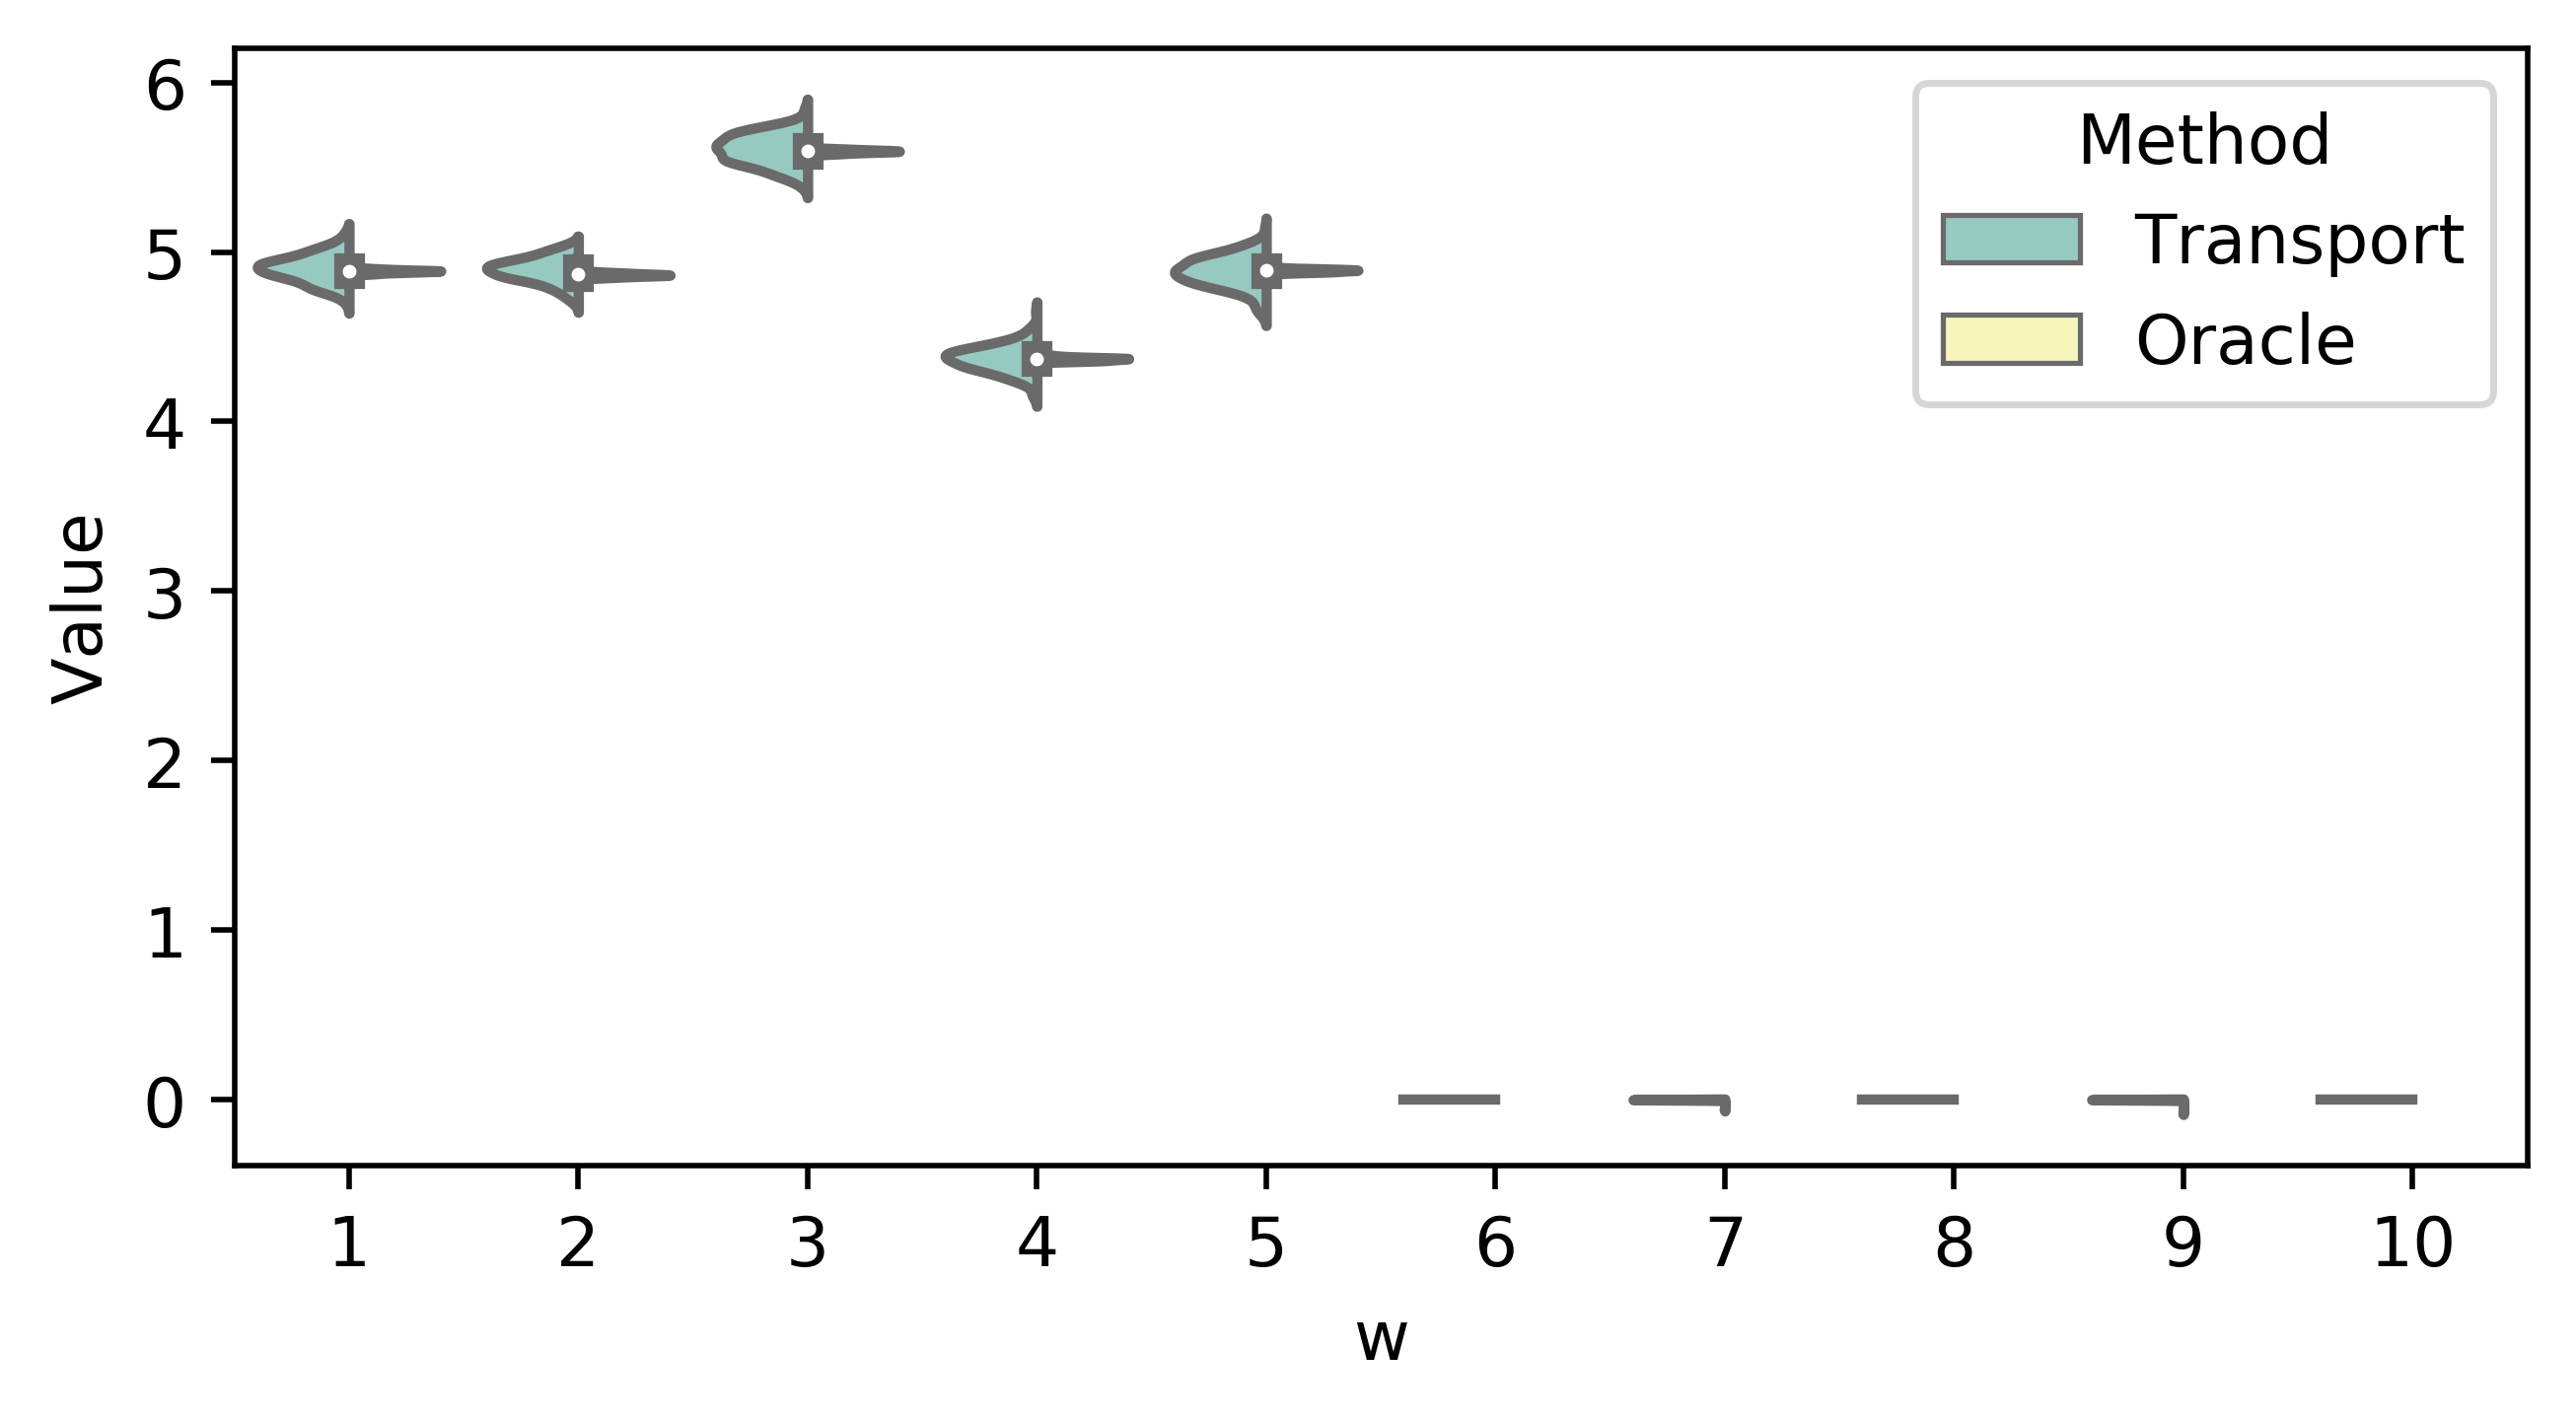

In [32]:
fig = plt.figure(figsize=(6, 3), dpi=500 )       # size in inches

ax = sns.violinplot(x="w", y="Value",data=w_long, hue="Method",
                    palette="Set3",
                    split=True,    scale="count")


Text(0.5, 0, 'batch')

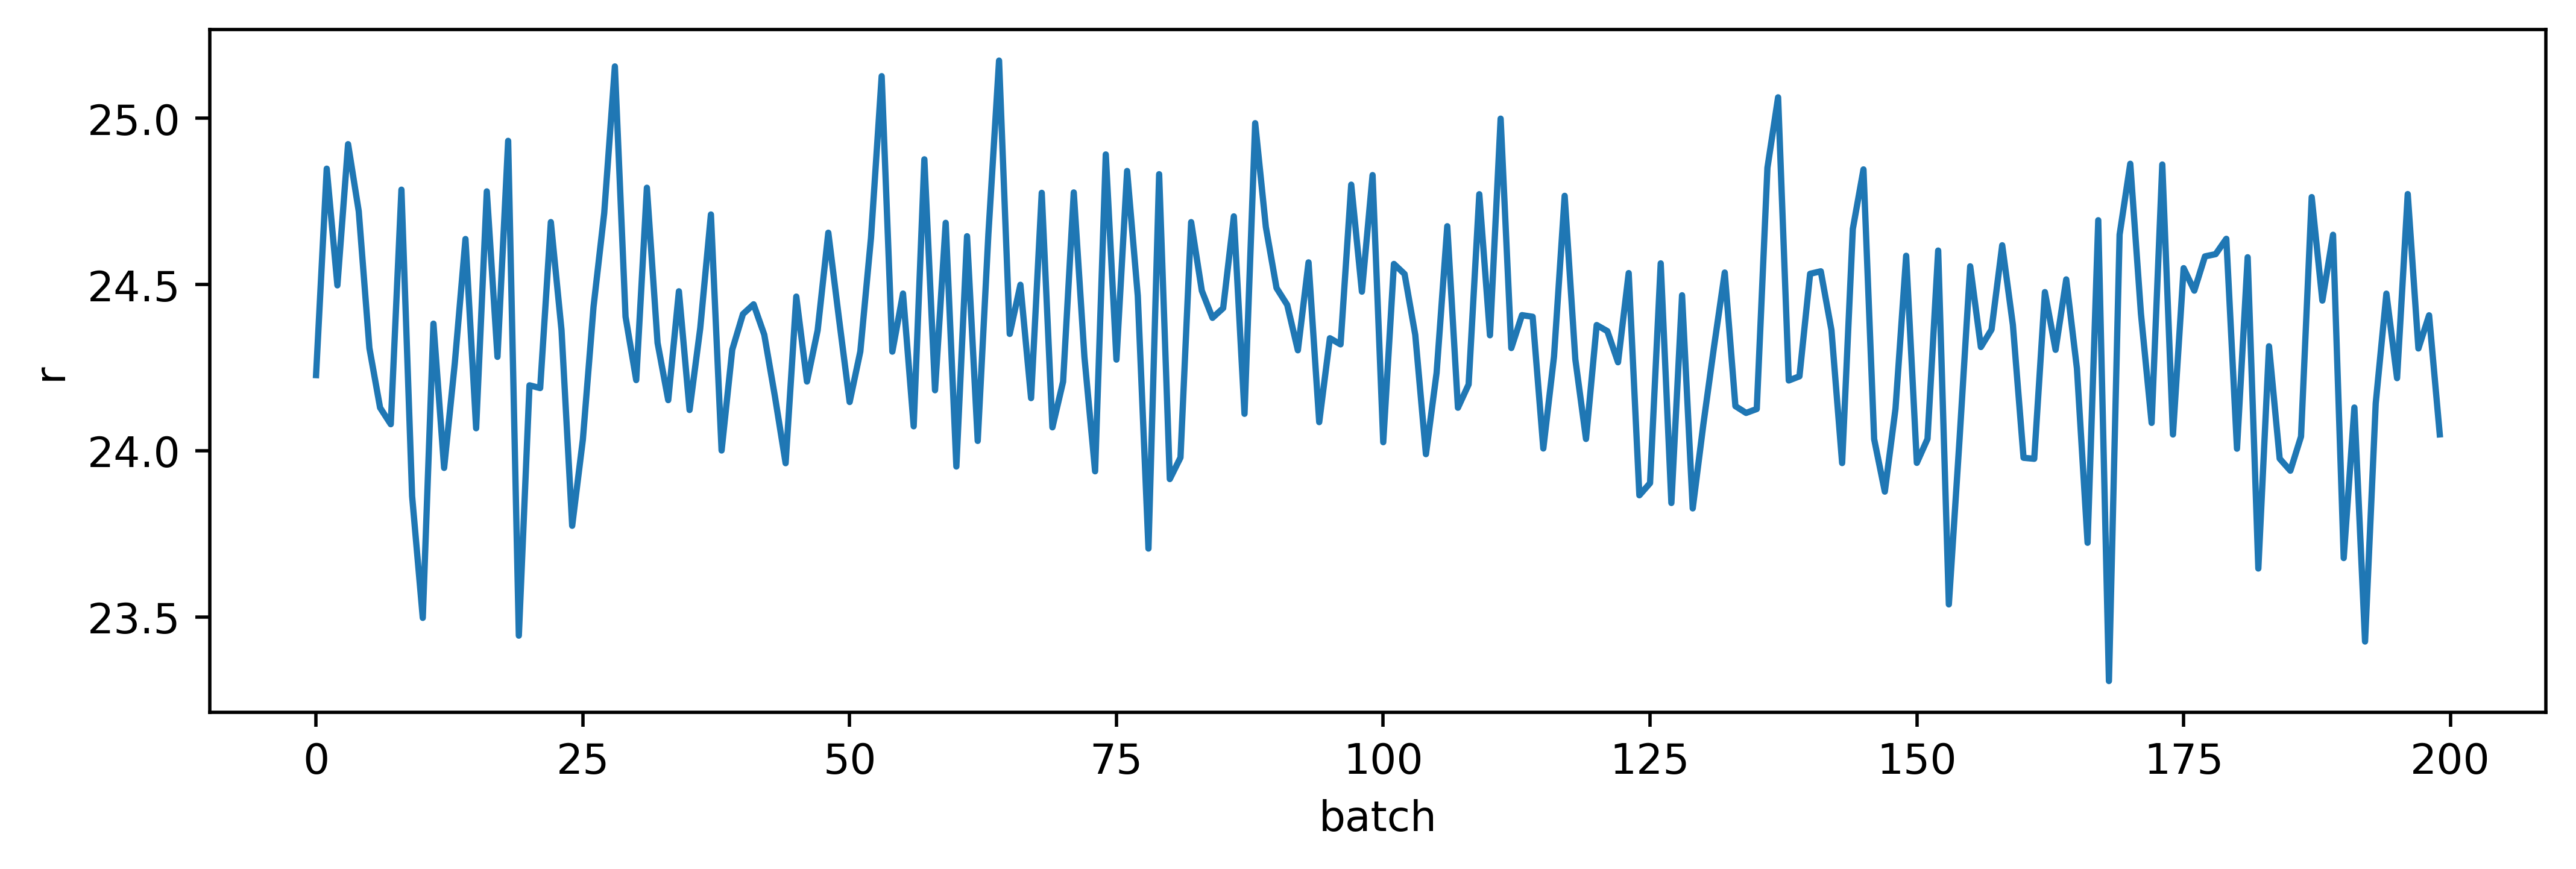

In [33]:
fig = plt.figure(figsize=(10, 3), dpi=500 )    
plt.plot(r.cpu().detach().numpy())
plt.ylabel("r")
plt.xlabel("batch")